In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('../../data/examples_train.csv', usecols=['example_id', 'query_id', 'product_id', 'esci_label'])

In [3]:
rank_label = {
    0: 1,
    0.01: 2,
    0.1: 3,
    1: 4,
}

In [4]:
train['rank_label'] = train['esci_label'].map(rank_label)

In [5]:
train['query_group_size'] = train.groupby('query_id').transform('size')

In [6]:
train = train.sort_values(['query_id', 'product_id'])

In [7]:
train.head()

,example_id,query_id,product_id,esci_label,rank_label,query_group_size
22,3523,116,B00M2DPUKI,0.1,3,40
23,3524,116,B00M2DPVFW,1.0,4,40
25,3525,116,B00X51IAOO,1.0,4,40
26,3526,116,B00X51IAR6,0.1,3,40
27,3527,116,B00X51IJ4K,1.0,4,40


In [8]:
train_query = np.load('../../data/train_query.npy')
train_title = np.load('../../data/train_title.npy')

In [9]:
train_query = train_query[train.index]
train_title = train_title[train.index]

In [10]:
train.shape

(172538, 6)

# Modeling

In [11]:
from lightgbm import LGBMRanker
import lightgbm as lgb
from sklearn.model_selection import GroupKFold

In [12]:
kfold = GroupKFold(n_splits=5)

In [13]:
train_idx, valid_idx = next(kfold.split(X=train, y=None, groups=train['query_id']))

In [14]:
train, valid = train.iloc[train_idx], train.iloc[valid_idx]

In [15]:
model = LGBMRanker(n_estimators=10000, random_state=42, n_jobs=-1)

In [16]:
train_feat = np.hstack([train_query[train_idx], train_title[train_idx]])
valid_feat = np.hstack([train_query[valid_idx], train_title[valid_idx]])

In [17]:
train_group = train.groupby('query_id').head(1)['query_group_size'].tolist()
valid_group = valid.groupby('query_id').head(1)['query_group_size'].tolist()

In [18]:
model.fit(train_feat, train['rank_label'].values, 
         group=train_group,
         eval_set=[(valid_feat, valid['rank_label'].values)],
         eval_group=[valid_group],
         eval_at=[1, 3],
         callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=True),
                    lgb.log_evaluation(0)]
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 152369
[LightGBM] [Info] Number of data points in the train set: 138030, number of used features: 600
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[30]	valid_0's ndcg@1: 0.709164	valid_0's ndcg@3: 0.72222


LGBMRanker(n_estimators=10000, n_jobs=-1, random_state=42)

In [19]:
model.best_iteration_

30

# Prediction

In [20]:
test = pd.read_csv('../../data/examples_test.csv', usecols=['example_id', 'query_id', 'product_id', 'esci_label'])

In [21]:
test['rank_label'] = test['esci_label'].map(rank_label)

In [22]:
test_query = np.load('../../data/test_query.npy')
test_title = np.load('../../data/test_title.npy')
test_feat = np.hstack([test_query, test_title])

In [23]:
test.shape, test_feat.shape

((64432, 5), (64432, 600))

In [24]:
test['pred'] = model.predict(test_feat)

In [25]:
test.head(20)

,example_id,query_id,product_id,esci_label,rank_label,pred
0,12756,438,B08PBJSJM8,0.1,3,-0.192038
1,12757,438,B087R9X5X7,1.0,4,-0.176171
2,12758,438,B0881K8XHS,0.1,3,-0.090894
3,12759,438,B089VZ3RY8,1.0,4,-0.193707
4,12760,438,B08H142Z8H,0.1,3,0.077221
5,12761,438,B08H163Q5G,1.0,4,-0.105212
6,12762,438,B08K35ZN26,1.0,4,-0.099671
7,12763,438,B093LDN6JM,1.0,4,-0.155512
8,12764,438,B086DQYLXH,1.0,4,0.012457
9,12765,438,B093LFS7PX,1.0,4,-0.204995


In [46]:
test[['rank_label', 'pred']].corr()

,rank_label,pred
rank_label,1.000000,0.131745
pred,0.131745,1.000000


In [26]:
from sklearn.metrics import ndcg_score

In [57]:
scores = []
for qid, gr in test.groupby('query_id'):
    if len(gr) > 1:
        ndcg = ndcg_score(np.asarray([gr['rank_label']]), np.asarray([gr['pred']]))
        scores.append(ndcg)

<Axes: >

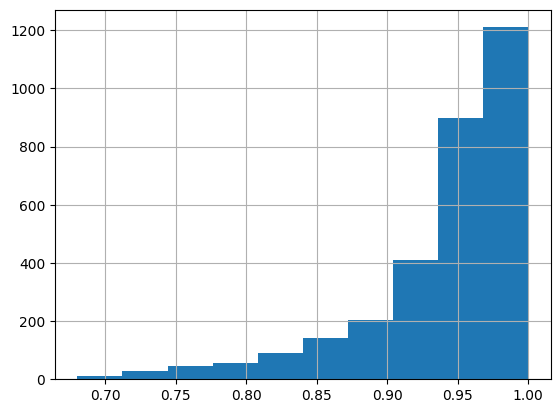

In [58]:
pd.Series(scores).hist()

In [59]:
pd.Series(scores).describe()

count    3092.000000
mean        0.941046
std         0.057794
min         0.680414
25%         0.922782
50%         0.957073
75%         0.981810
max         1.000000
dtype: float64